# SAM Analysis
Designed to calculate and plot the SAM. Link to [Data analysis](#Data-Analysis).

#### Dask

<br>

#### Choices for data

In [ ]:
#Experiment data for analysis
dataVariableId = 'psl'
dataSourceId = "UKESM1-0-LL"
experimentId = "historical"
tableId = "Amon"
memberId = "r1i1p1f2"

externalSAMFileName = "SAMIndex.txt"

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
maskName = "OceanMaskVolcello2"

<br>

#### Imports

In [2]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Data loading
<b>Loading the ESM data</b>

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq(dataVariableId) & df.source_id.eq(dataSourceId) & df.table_id.eq(tableId) & df.experiment_id.eq(experimentId)& df.member_id.eq(memberId)]
#dfFilt = dfFilt[df.member_id.eq(memberId)] #selected member ID

zstore = dfFilt.zstore.values[0]
mapper = fsspec.get_mapper(zstore)
fileRaw = xr.open_zarr(mapper, consolidated=True)

#Formatting dates into np.datetime64 format
startDateIterate = np.datetime64(fileRaw['time'].values[0],'M')
endDateIterate = np.datetime64(fileRaw['time'].values[-1],'M') + np.timedelta64(1,'M')
fileRaw['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
fileRaw['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 

dfESMLat = fileRaw.psl.sel(lat=latSel) #Selection of latitude
dfESMLat = dfESMLat.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLat["time"][0].values
globalDateInc = dfESMLat["time"][1].values - globalStartDate
globalEndDateIn = dfESMLat["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("ESM data sucessfully loaded.")

ESM data sucessfully loaded.


<br>
<b>Loading the ocean mask</b>

In [4]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask Loaded into oceanMask")

Mask Loaded into oceanMask


<br>
<b>Loading external SAM Index</b>

In [5]:
externalSAMIndex = np.loadtxt("SAMIndex.txt", skiprows=1, max_rows=64)
externalSAMIndexYear = np.transpose(externalSAMIndex)[0]
externalSAMIndexSort = np.empty(shape=(0,2))
for i in range(len(externalSAMIndexYear)):
    for j in range(1,13):
        externalSAMIndexSort = np.append(externalSAMIndexSort, [[np.datetime64(str(int(externalSAMIndexYear[i]))+"-"+f"{j:02d}", "M"), externalSAMIndex[i][j]]], axis=0)
externalSAMIndexSort = np.transpose(externalSAMIndexSort)
print("External SAM index data in "+externalSAMFileName+" loaded into externalSAMIndexSort.")

External SAM index data in SAMIndex.txt loaded into externalSAMIndexSort.


<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
<li>externalSAMSearch - returns externalSAMIndexSort between two dates.
<li>SAMCalculateRaw - returns a data array of the difference in pressures between lat -40 and lat -65 (tolerance ±1°) for an input data array, not normalised .
<li>SAMCalculateNorm - returns a data array of the difference in pressures between lat -40 and lat -65 (tolerance ±1°) for an input data array, normalised using second input data array.
</ul>

In [6]:
def externalSAMSearch(startDate, endDate):
    '''Performs np searching across externalSAMIndexSort for start-end date data, returns 2 x n np.array containing [dates][data]'''
    x, startIndex = np.where(externalSAMIndexSort == np.datetime64(startDate, 'M'))
    x, endIndex = np.where(externalSAMIndexSort == np.datetime64(endDate, 'M'))
    dateArray = externalSAMIndexSort[0][startIndex[0] : endIndex[0] + 1]
    dataArray = externalSAMIndexSort[1][startIndex[0] : endIndex[0] + 1]
    externalSAMSearch = np.append([dateArray], [dataArray], axis=0)
    return externalSAMSearch

def SAMCalculateRaw(dataArray):
    '''Calculates the SAM index not normalised, returns SAM index data Array.'''
    P40 = dataArray.sel(lat=slice(-41, -39))
    P40 = P40.mean(dim=["lat", "lon"])
    P40 = P40.reset_coords(drop=True)
    P65 = dataArray.sel(lat=slice(-66, -64))
    P65 = P65.mean(dim=["lat", "lon"])
    P65 = P65.reset_coords(drop=True)
    SAMIndex = P40 - P65
    return SAMIndex

def SAMCalculateNorm(dataArray, normalisedDataArray):
    '''Calculates the SAM index, normalised using the second data array. Returns SAM index data Array.'''
    normalisedDataNP = normalisedDataArray.values
    SAMIndexRaw = SAMCalculateRaw(dataArray)
    
    dates = pd.DatetimeIndex(SAMIndexRaw["time"].values)
    dateLen = len(dates.year.unique().values)
    startMon = dates[0].month - 1
    endMon = -13 + dates[-1].month
    
    normalisedDataNPList = np.empty(shape=(0,12))
    for i in range(dateLen):
        normalisedDataNPList = np.append(normalisedDataNPList, normalisedDataNP)

    normalisedDataNPList = np.append(normalisedDataNPList, 0) #Adding empty element to allow for refencing end point
    SAMIndexNorm = SAMIndexRaw - normalisedDataNPList[startMon:endMon]
    
    return SAMIndexNorm

print("Calculation functions defined")

Calculation functions defined


<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li> mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number.
<li> timePlot -  plots the SAM index in the input data array over time.
<li> timePlotStd - plots the SAM index for a 12 month period (starting January) with error bars.
<li> timePlotYear - plots the SAM index for a 12 month period (starting January) without error bars. Compatible with timePlotStd.
<li> timePlotDecade - plots the SAM index for an input data array over a decade period. Start date is dispalyed as 2001-01.
</ul>

In [7]:
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map.'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))

    
def timePlot(dataArray, title, plotNo):
    '''Displays SAM index over time for any given range.'''
    plt.figure(plotNo, figsize = (20,10))
    dataArray.plot(label = dataArray.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel("SAM Index")
    plt.title(str(title))
    
    
def timePlotStd(dataSetMean, dataSetError, title, plotNo):
    '''Displays SAM index with standard deviations over a 12 month period.'''
    plt.figure(plotNo, figsize = (10,10))
    plt.errorbar(months, dataSetMean.values, yerr=dataSetError.values, label = dataSetMean.name, capsize=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Month")
    plt.ylabel("SAM Index")
    plt.title(str(title))
    
    
def timePlotYear(dataArray, title, plotNo):
    '''Displays SAM index for a 12 month period starting in January. Compatible with timePlotStd.'''
    plt.figure(plotNo, figsize = (10,10))
    plt.plot(months, dataArray.values, label = dataArray.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Month")
    plt.ylabel("SAM Index")
    plt.title(str(title))

def timePlotDecade(dataArray, title, plotNo):
    '''Displays SAM index over a decade.'''
    timeAxis = np.arange(np.datetime64("2001-01"), np.datetime64("2011-01"), np.timedelta64(1, 'M'), dtype='datetime64[M]')
    plt.figure(plotNo, figsize = (20,10))
    plt.plot(timeAxis, dataArray.values, label = dataArray.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel("SAM Index")
    plt.xlabel("Time")
    plt.title(str(title))
    
print("Plotting functions defined")

Plotting functions defined


<br>

#### Plotting the mask

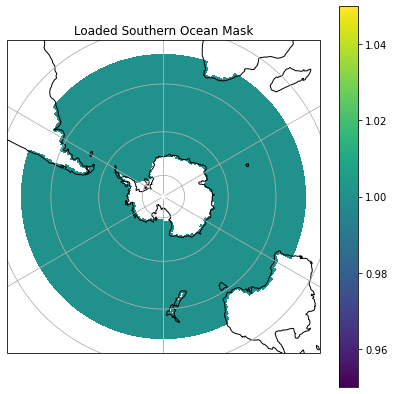

In [8]:
mapPlot(oceanMask, "Loaded Southern Ocean Mask", 1)

<br>

#### Data Analysis
<b>SAM index (2014-15) not normalised </b>

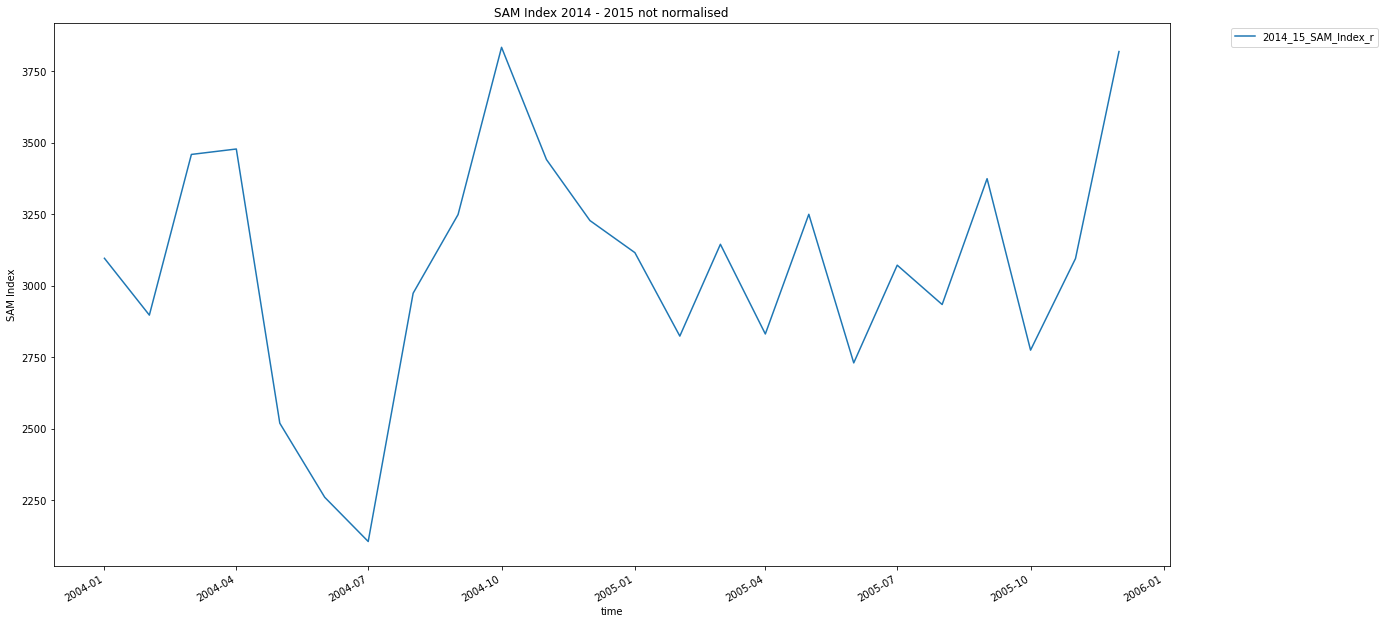

In [9]:
SAM2014_15 = SAMCalculateRaw(dfESMLat.sel(time=slice('2004-01','2005-12')))
SAM2014_15.name = "2014_15_SAM_Index_r" #_r indicates raw, meaning not normalised
timePlot(SAM2014_15, "SAM Index 2014 - 2015 not normalised", 1)
plt.show()

<br>
<b>SAM index (1971-2000) not normalised </b><br>
This data set will be averaged and used to normalise the SAM index calculated.

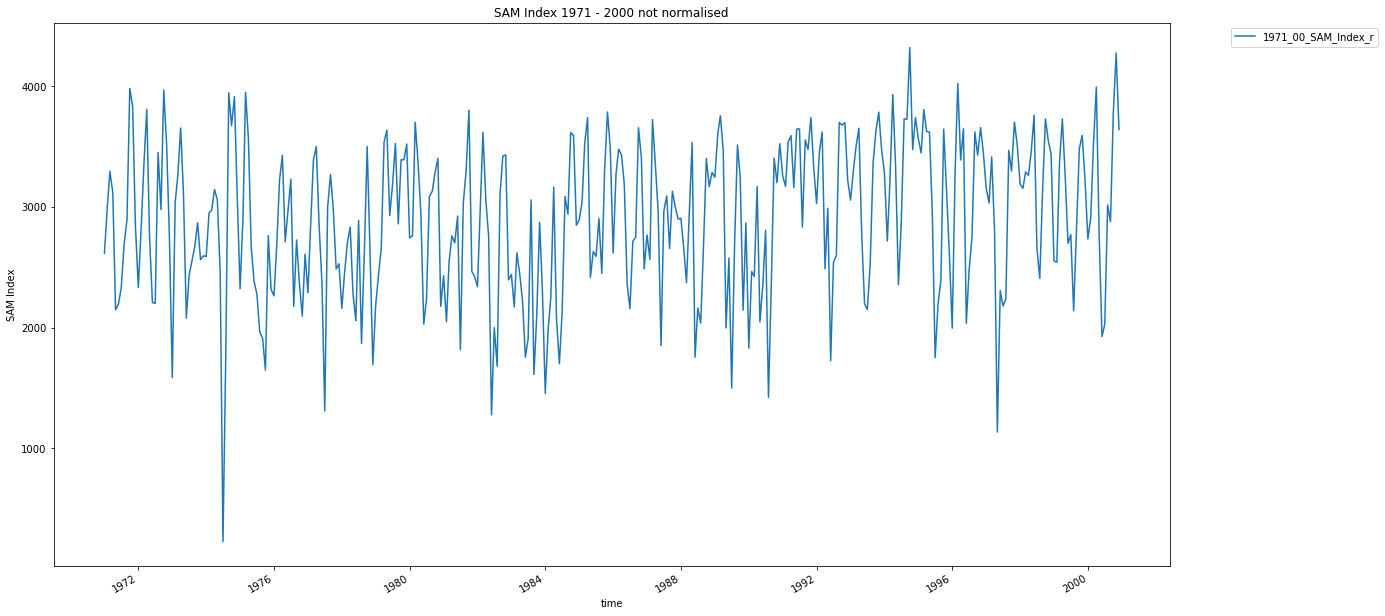

In [10]:
SAM1971_00 = SAMCalculateRaw(dfESMLat.sel(time=slice('1971-01','2000-12')))
SAM1971_00.name = "1971_00_SAM_Index_r" #_r indicates raw, meaning not normalised
timePlot(SAM1971_00, "SAM Index 1971 - 2000 not normalised", 1)
plt.show()

<br>
<b>SAM index (1971-2000) monthly average</b>

In [11]:
#SAM calculation for 1971 - 2000
SAMNormaliseMonthly = SAM1971_00.groupby("time.month")
SAMNormaliseMonthlyMeans = SAMNormaliseMonthly.mean("time", keep_attrs=True)
SAMNormaliseMonthlyStds = SAMNormaliseMonthly.std("time", keep_attrs=True)
SAMNormaliseMonthlyMeans.name = "1971_2000_SAM_Index_mean" #_r indicates raw, meaning not normalised

#SAM calculation for 1971 and 2000
SAM1971 = SAMCalculateRaw(dfESMLat.sel(time=slice("1971-01","1971-12")))
SAM1971.name = "1971_SAM_Index_r"
SAM2000 = SAMCalculateRaw(dfESMLat.sel(time=slice("2000-01","2000-12")))
SAM2000.name = "2000_SAM_Index_r"

#SAM calculation for 1971 and 2000 normalised
SAM1971N = SAMCalculateNorm(dfESMLat.sel(time=slice("1971-01","1971-12")), SAMNormaliseMonthlyMeans)
SAM1971N.name = "1971_SAM_Index_n"
SAM2000N = SAMCalculateNorm(dfESMLat.sel(time=slice("2000-01","2000-12")), SAMNormaliseMonthlyMeans)
SAM2000N.name = "2000_SAM_Index_n"
print("SAM index for 1971-2000 calculated, with years 1971 and 2000 additionally calculated on a single year basis raw and normalised.")

SAM index for 1971-2000 calculated, with years 1971 and 2000 additionally calculated on a single year basis raw and normalised.


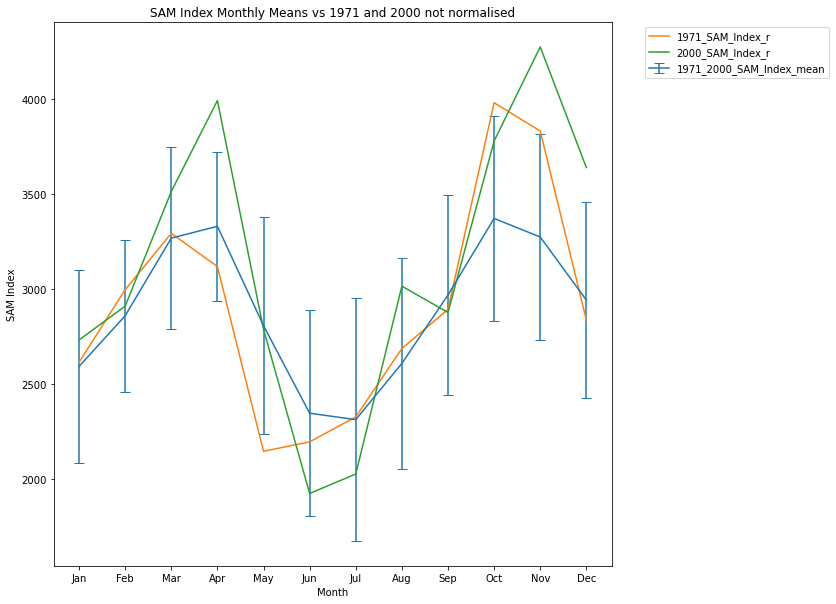

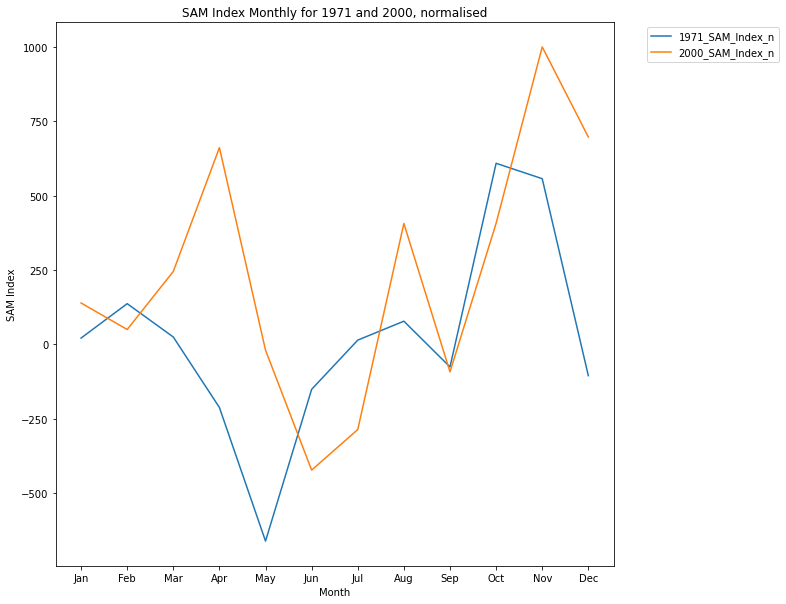

In [12]:
timePlotStd(SAMNormaliseMonthlyMeans, SAMNormaliseMonthlyStds, "SAM Index Monthly Means 1971 - 2000 not normalised", 1)
timePlotYear(SAM1971, "SAM Index Monthly Means vs 1971 not normalised", 1)
timePlotYear(SAM2000, "SAM Index Monthly Means vs 1971 and 2000 not normalised", 1)
timePlotYear(SAM1971N, "SAM Index Monthly for 1971, normalised", 2)
timePlotYear(SAM2000N, "SAM Index Monthly for 1971 and 2000, normalised", 2)
plt.show()

<br>
<b>Normalised SAM for a selected time period</b>

In [13]:
testData = dfESMLat.sel(time=slice('1971-01','1973-12'))
testSAM = SAMCalculateRaw(testData)
testSAM.name = "1971_73_SAM_Index_r"
testSAMN = SAMCalculateNorm(testData, SAMNormaliseMonthlyMeans)
testSAMN.name = "1971_73_SAM_Index_n"

dates = pd.DatetimeIndex(testSAM["time"].values)
dateLen = len(dates.year.unique().values)
normalisedDataNP = SAMNormaliseMonthlyMeans.values
normalisedDataNPList = np.empty(shape=(0,12))
for i in range(dateLen):
    normalisedDataNPList = np.append(normalisedDataNPList, normalisedDataNP)
    
print("SAM index for selected time period calculated.")

SAM index for selected time period calculated.


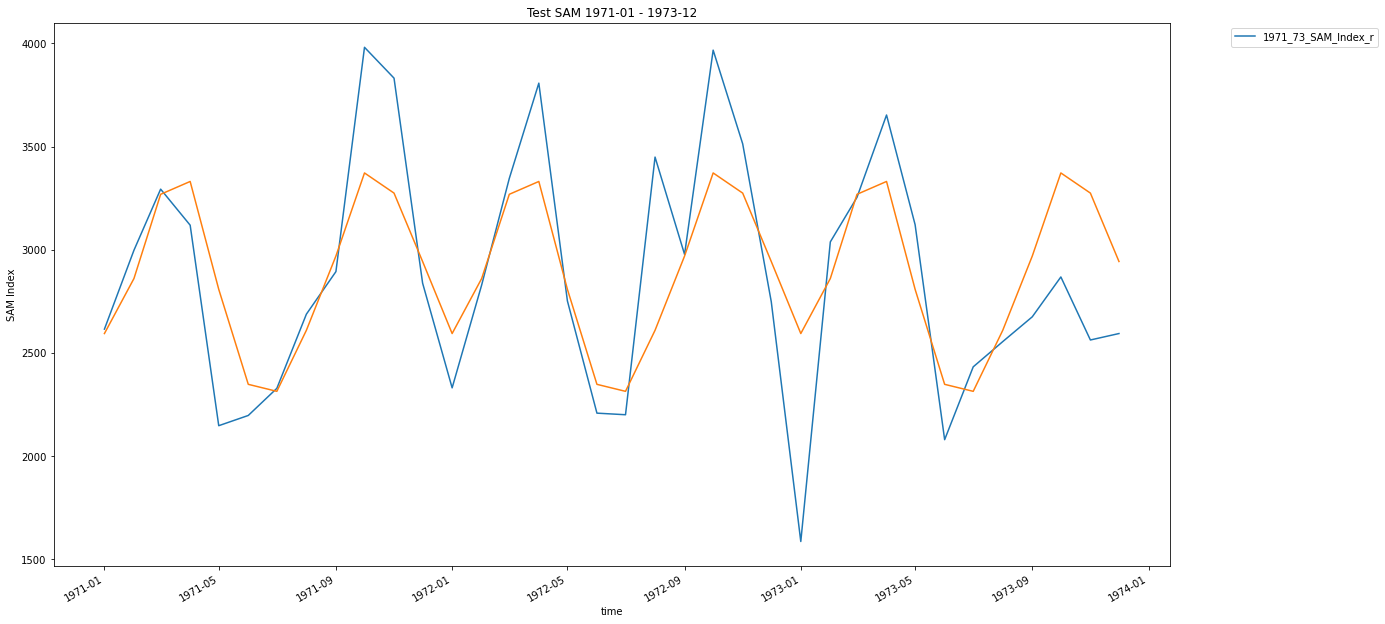

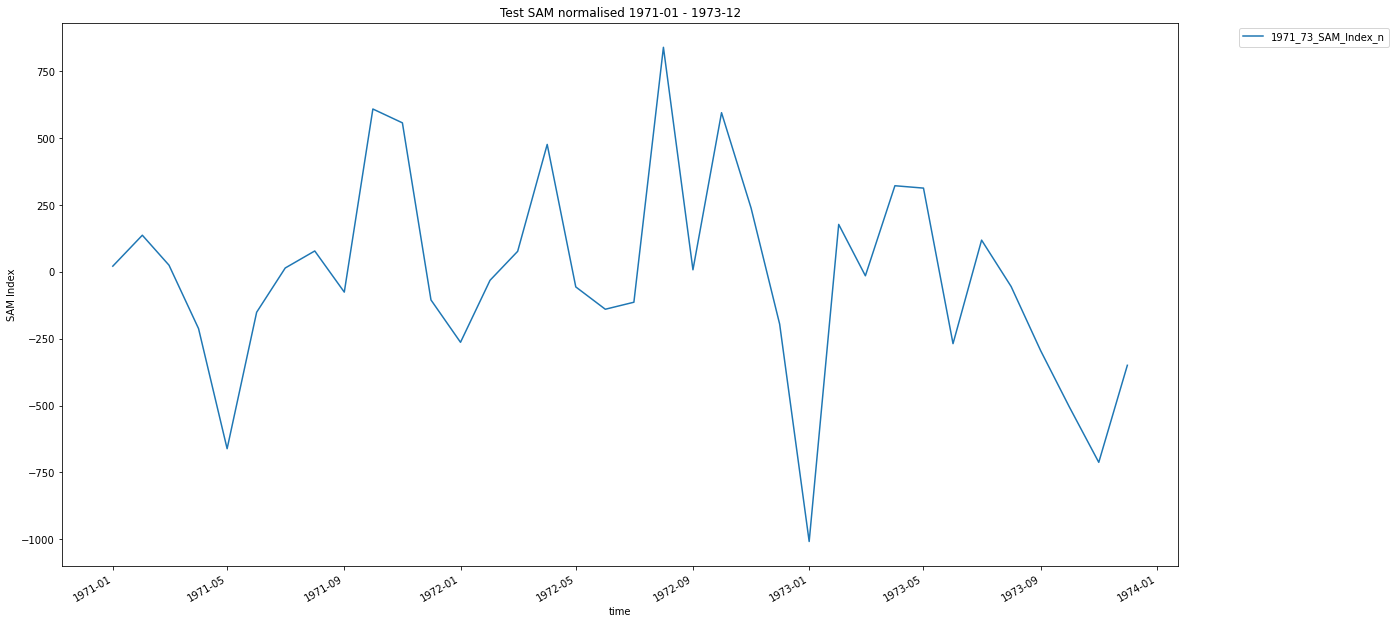

In [14]:
timePlot(testSAM, "Test SAM 1971-01 - 1973-12", 1)
ax = plt.plot(testSAM["time"],normalisedDataNPList, label = "1971_00_SAM_Index_mean")
timePlot(testSAMN, "Test SAM normalised 1971-01 - 1973-12", 2)
plt.show()

<br>
<b>Decade SAM Index comparison</b><br>
As different decades are being compared the time axis uses 2001 to represent the starting date.

In [15]:
SAM1971_80N = SAMCalculateNorm(dfESMLat.sel(time=slice("1971-01","1980-12")), SAMNormaliseMonthlyMeans)
SAM1971_80N.name = "1971_80_SAM_Index_n"
SAM1991_00N = SAMCalculateNorm(dfESMLat.sel(time=slice("1991-01","2000-12")), SAMNormaliseMonthlyMeans)
SAM1991_00N.name = "1991_00_SAM_Index_n"
SAM2005_14N = SAMCalculateNorm(dfESMLat.sel(time=slice("2005-01","2014-12")), SAMNormaliseMonthlyMeans)
SAM2005_14N.name = "2005_14_SAM_Index_n"
print("Decade normalised SAMs calculated (1971-80, 1991-2000, 2005-14).")

Decade normalised SAMs calculated (1971-80, 1991-2000, 2005-14).


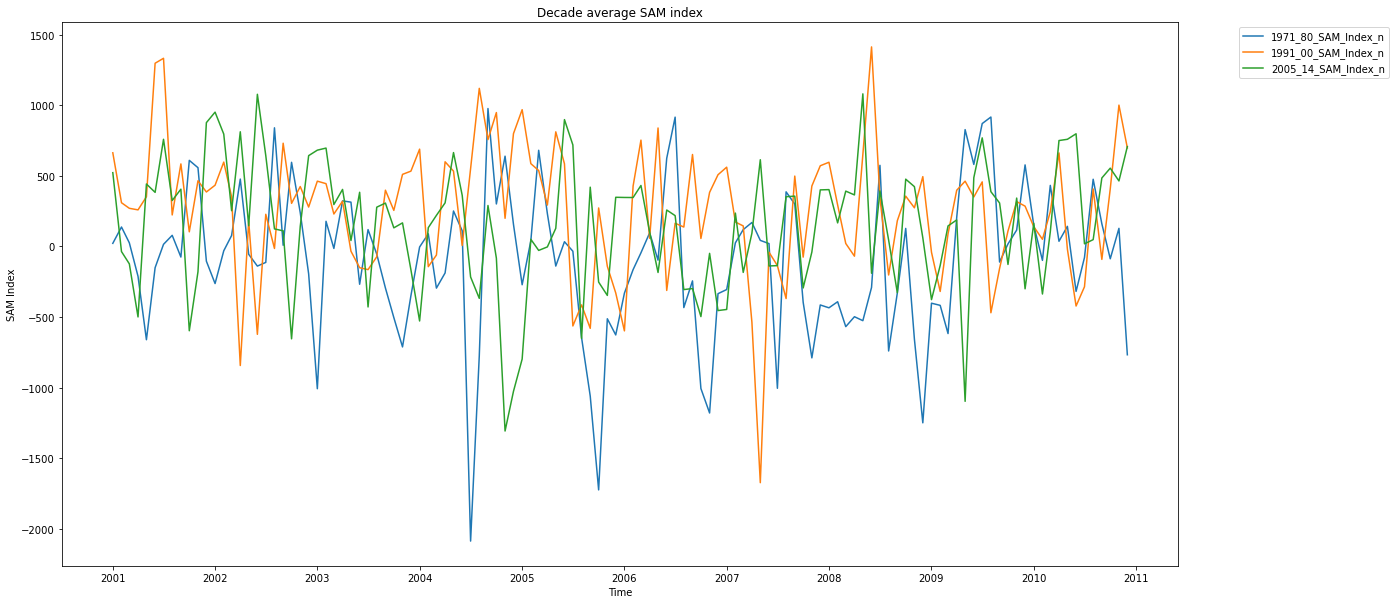

In [16]:
timePlotDecade(SAM1971_80N, "Decade average SAM index", 1)
timePlotDecade(SAM1991_00N, "Decade average SAM index", 1)
timePlotDecade(SAM2005_14N, "Decade average SAM index", 1)
plt.show()

<br>
<b>Imported SAM Index Comparison</b>

In [17]:
samCompData = dfESMLat.sel(time=slice('1957-01','2014-12'))
calcSAMN = SAMCalculateNorm(samCompData, SAMNormaliseMonthlyMeans)
calcSAMN.name = "1957_14_SAM_Index_n"
print("Calculated normalised SAM Index for 1957-01 to 2014-12, stored in 1957_14_SAM_Index_n.")

Calculated normalised SAM Index for 1957-01 to 2014-12, stored in 1957_14_SAM_Index_n.


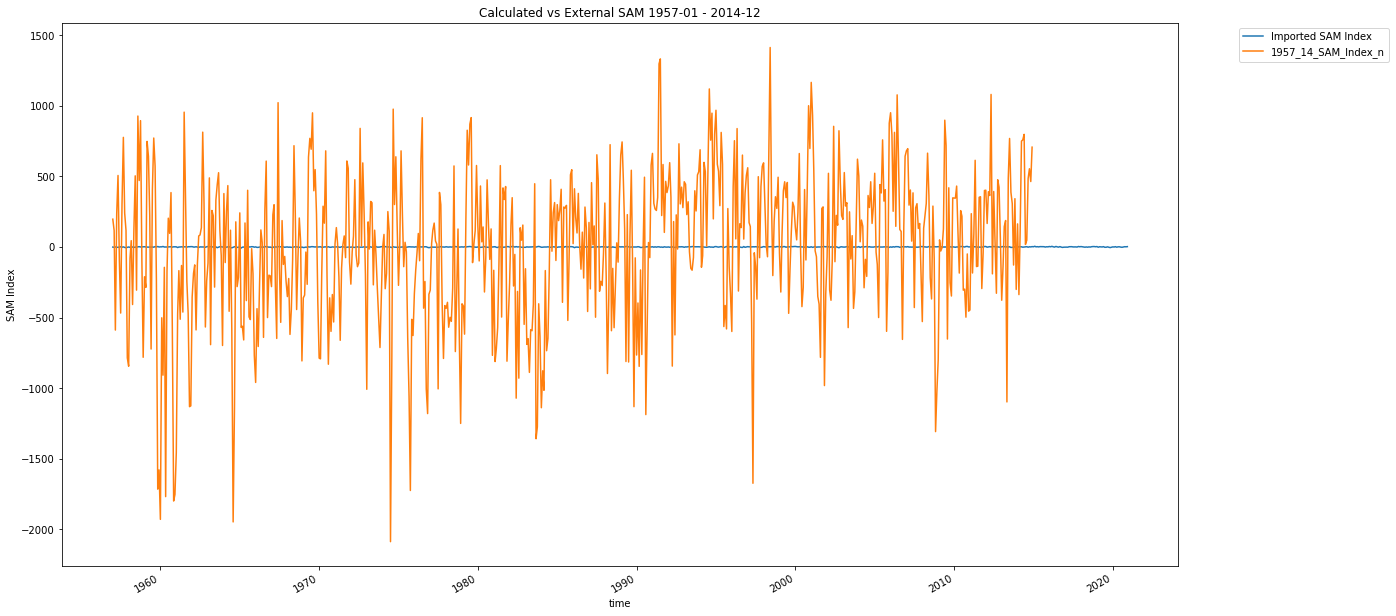

In [18]:
plt.figure(1, figsize=(20,10))
plt.plot(externalSAMIndexSort[0], externalSAMIndexSort[1], label="Imported SAM Index")
timePlot(calcSAMN, "Calculated vs External SAM 1957-01 - 2014-12", 1)
plt.show()

In [19]:
startDate, endDate = "2005-01","2014-12"
extSAM2005_14 = externalSAMSearch(startDate, endDate)

samCompData200514 = dfESMLat.sel(time=slice(startDate, endDate))
calcSAMN2005_14 = SAMCalculateNorm(samCompData200514, SAMNormaliseMonthlyMeans)
calcSAMN2005_14.name = "2005_14_SAM_Index_n"
print("External and Calculated SAM Index values identifed for time period "+startDate+" - "+endDate+".")

External and Calculated SAM Index values identifed for time period 2005-01 - 2014-12.


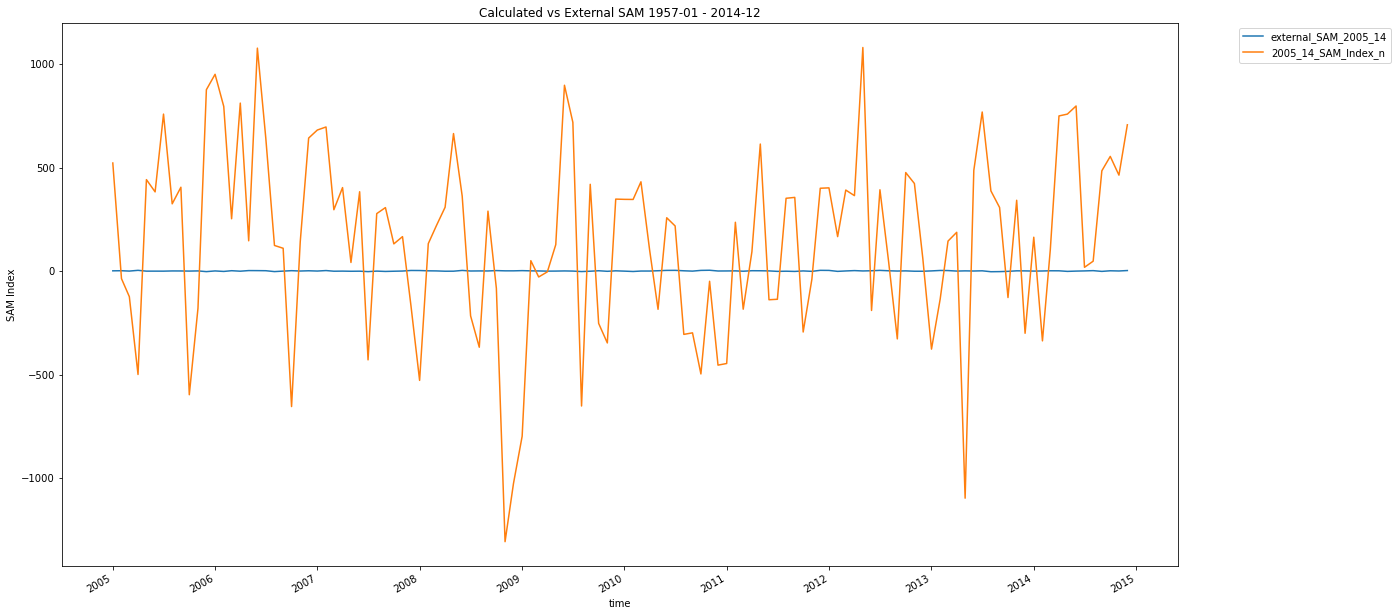

In [20]:
plt.figure(1, figsize=(20,10))
plt.plot(extSAM2005_14[0], extSAM2005_14[1], label="external_SAM_2005_14")
timePlot(calcSAMN2005_14, "Calculated vs External SAM 1957-01 - 2014-12", 1)
plt.show()